In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from utils import save, unpickle, pixel_range, preprocess, hist_kde
from vae_gans import MNIST_VAE_GAN, Projection
from classifiers import MNIST_CNN
from attacks import GM

os.environ["CUDA_VISIBLE_DEVICES"]="2"

mnist = input_data.read_data_sets("MNIST_data/")

data_train = (np.reshape(mnist.train.images, [-1, 28, 28, 1]) * 2.0 - 1, mnist.train.labels)
data_test = (np.reshape(mnist.test.images, [-1, 28, 28, 1]) * 2.0 - 1, mnist.test.labels)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

DNN = MNIST_CNN('tf_logs/exp1/standard/', activation=tf.nn.relu)
DNN.load(sess)

loss = -tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.stop_gradient(tf.one_hot(DNN.yi, depth=DNN.n_classes)), logits=DNN.logits)

loss_grad = tf.gradients(loss, DNN.X)[0]

r1 = preprocess(sess.run(loss_grad, feed_dict={DNN.X: data_test[0][:100]}), q1=0.5, q2=99.5)

sess.close()

tf.reset_default_graph()

sess = tf.InteractiveSession()

DNN = MNIST_CNN('tf_logs/exp1/adv/GM/0.4_0.02_40_inf_xent/', activation=tf.nn.relu)
DNN.load(sess)

loss = -tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.stop_gradient(tf.one_hot(DNN.yi, depth=DNN.n_classes)), logits=DNN.logits)

loss_grad = tf.gradients(loss, DNN.X)[0]

r2 = preprocess(sess.run(loss_grad, feed_dict={DNN.X: data_test[0][:100]}), q1=0.5, q2=99.5)

sess.close()

tf.reset_default_graph()

sess = tf.InteractiveSession()

DNN = MNIST_CNN('tf_logs/exp1/adv/GM/4_2_40_2_xent/', activation=tf.nn.relu)
DNN.load(sess)

loss = -tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.stop_gradient(tf.one_hot(DNN.yi, depth=DNN.n_classes)), logits=DNN.logits)

loss_grad = tf.gradients(loss, DNN.X)[0]

r3 = preprocess(sess.run(loss_grad, feed_dict={DNN.X: data_test[0][:100]}), q1=0.5, q2=99.5)

sess.close()

INFO:tensorflow:Restoring parameters from tf_logs/exp2/standard/model
INFO:tensorflow:Restoring parameters from tf_logs/exp2/adv/GM/0.4_0.02_40_inf_xent/model
INFO:tensorflow:Restoring parameters from tf_logs/exp2/adv/GM/4_2_40_2_xent/model


In [ ]:
inds = [1, 3, 5]

plt.figure(figsize=(9,12))

for i, ind in enumerate(inds):

    plt.subplot(4, 3, i + 1)
    plt.imshow(data_test[0][ind].reshape(28,28), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(data_test[1][ind], fontsize=25)
    if i == 0: plt.ylabel('Original', fontsize=25)

    plt.subplot(4, 3, 4 + i)
    v, _ = pixel_range(r1[ind])
    plt.imshow(r1[ind].reshape(28,28), vmin=v[0], vmax=v[1], cmap='bwr')
    plt.xticks([])
    plt.yticks([])
    if i == 0: plt.ylabel('Standard', fontsize=25)

    plt.subplot(4, 3, 7 + i)
    v, _ = pixel_range(r2[ind])
    plt.imshow(r2[ind].reshape(28,28), vmin=v[0], vmax=v[1], cmap='bwr')
    plt.xticks([])
    plt.yticks([])
    if i == 0: plt.ylabel('L-Inf Trained', fontsize=25)

    plt.subplot(4, 3, 10 + i)
    v, _ = pixel_range(r3[ind])
    plt.imshow(r3[ind].reshape(28,28), vmin=v[0], vmax=v[1], cmap='bwr')
    plt.xticks([])
    plt.yticks([])
    if i == 0: plt.ylabel('L2 Trained', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(wspace=0.04, hspace=0.04)

plt.savefig('figs/mnist_loss_grad.jpg', bbox_inches='tight', dpi=300)

plt.show()

plt.close()

In [2]:
def evaluate(tf_logs, attack_params, savedir=None):
    
    datasets = []
    reconsts = []
    suc_inds = []
    l2_dists = []

    print('Generating Adversarial Attacks')

    for i, (name, tf_log) in enumerate(tf_logs):

        if not tf_log:
            datasets.append((name, data_test[0]))
            continue

        tf.reset_default_graph()

        sess = tf.InteractiveSession()

        DNN = MNIST_CNN(tf_log, activation=tf.nn.relu)
        DNN.load(sess)

        gm = GM(DNN, **attack_params)
        datasets.append((name, gm.attack(sess, data_test, batch_size=500)))

        sess.close()
    
    print('Generating Projections')

    tf.reset_default_graph()

    sess = tf.InteractiveSession()

    vae_gan = MNIST_VAE_GAN('tf_logs/exp1/vae-gan/data/')
    vae_gan.load(sess)

    for (name, dataset) in datasets:

        reconsts.append((name, vae_gan.reconstruct(sess, (dataset, 0))))

    sess.close()
    
    print('Removing Unsuccessful Attacks')
    
    tf.reset_default_graph()
    
    sess = tf.InteractiveSession()
    
    DNN = MNIST_CNN('tf_logs/exp1/standard/', activation=tf.nn.relu)
    DNN.load(sess)
    
    org_ys = DNN.inference(sess, data_test, batch_size=500)
    
    for (name, dataset) in datasets:
        
        adv_ys = DNN.inference(sess, (dataset, 0), batch_size=500)
        
        if name == 'Test Data':
            suc_inds.append(org_ys == adv_ys)
        else:
            suc_inds.append(org_ys != adv_ys)
    
    sess.close()
    
    print('Calculating L2 Distances')

    for i, ((name, dataset), (_, reconst)) in enumerate(zip(datasets, reconsts)):

        l2_dist = np.sqrt(np.sum(np.square(dataset[suc_inds[i]] - reconst[suc_inds[i]]), axis=(1,2,3)))
        l2_dists.append((name, l2_dist))
    
    return datasets, reconsts, l2_dists

In [34]:
tf_logs1 = [('Test Data' , None), 
            ('Standard'  , 'tf_logs/exp1/standard/'), 
            ('L2 1 XEnt' , 'tf_logs/exp1/adv/GM/1_2_40_2_xent/'), 
            ('L2 2 XEnt' , 'tf_logs/exp1/adv/GM/2_2_40_2_xent/'), 
            ('L2 4 XEnt' , 'tf_logs/exp1/adv/GM/4_2_40_2_xent/'), 
           ]

tf_logs2 = [('Test Data' , None),
            ('Standard'  , 'tf_logs/exp1/standard/'), 
            ('L2 1 CW'   , 'tf_logs/exp1/adv/GM/1_2_40_2_cw/'),
            ('L2 2 CW'   , 'tf_logs/exp1/adv/GM/2_2_40_2_cw/'), 
            ('L2 4 CW'   , 'tf_logs/exp1/adv/GM/4_2_40_2_cw/')
           ]

tf_logs3 = [('Test Data'       , None), 
            ('Standard'        , 'tf_logs/exp1/standard/'), 
            ('L-Inf 0.05 XEnt' , 'tf_logs/exp1/adv/GM/0.05_0.02_40_inf_xent/'), 
            ('L-Inf 0.1 XEnt'  , 'tf_logs/exp1/adv/GM/0.1_0.02_40_inf_xent/'), 
            ('L-Inf 0.2 XEnt'  , 'tf_logs/exp1/adv/GM/0.2_0.02_40_inf_xent/'), 
           ]

tf_logs4 = [('Test Data'     , None),
            ('Standard'      , 'tf_logs/exp1/standard/'), 
            ('L-Inf 0.05 CW' , 'tf_logs/exp1/adv/GM/0.05_0.02_40_inf_cw/'), 
            ('L-Inf 0.1 CW'  , 'tf_logs/exp1/adv/GM/0.1_0.02_40_inf_cw/'), 
            ('L-Inf 0.2 CW'  , 'tf_logs/exp1/adv/GM/0.2_0.02_40_inf_cw/'), 
           ]

# attack_params = {'eps': 12, 'step_size': 2, 'n_steps': 40, 'norm': '2', 'loss_type': 'xent'}
attack_params = {'eps': 12, 'step_size': 2, 'n_steps': 40, 'norm': '2', 'loss_type': 'cw'}

ress = []

for tf_logs in [tf_logs1, tf_logs2, tf_logs3, tf_logs4]:
    
    ress.append(evaluate(tf_logs, attack_params))

save(ress, 'results/gradient/exp1/results_{}.pickle'.format(attack_params['loss_type']))

Generating Adversarial Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp2/standard/model


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp2/adv/GM/1_2_40_2_xent/model


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp2/adv/GM/2_2_40_2_xent/model


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp2/adv/GM/4_2_40_2_xent/model


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Generating Projections
INFO:tensorflow:Restoring parameters from tf_logs/exp2/vae-gan/data/model
Removing Unsuccessful Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp2/standard/model
Calculating L2 Distances
Generating Adversarial Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp2/standard/model


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp2/adv/GM/1_2_40_2_cw/model


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp2/adv/GM/2_2_40_2_cw/model


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp2/adv/GM/4_2_40_2_cw/model


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Generating Projections
INFO:tensorflow:Restoring parameters from tf_logs/exp2/vae-gan/data/model
Removing Unsuccessful Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp2/standard/model
Calculating L2 Distances
Generating Adversarial Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp2/standard/model


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp2/adv/GM/0.05_0.02_40_inf_xent/model


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp2/adv/GM/0.1_0.02_40_inf_xent/model


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp2/adv/GM/0.2_0.02_40_inf_xent/model


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Generating Projections
INFO:tensorflow:Restoring parameters from tf_logs/exp2/vae-gan/data/model
Removing Unsuccessful Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp2/standard/model
Calculating L2 Distances
Generating Adversarial Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp2/standard/model


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp2/adv/GM/0.05_0.02_40_inf_cw/model


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp2/adv/GM/0.1_0.02_40_inf_cw/model


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp2/adv/GM/0.2_0.02_40_inf_cw/model


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Generating Projections
INFO:tensorflow:Restoring parameters from tf_logs/exp2/vae-gan/data/model
Removing Unsuccessful Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp2/standard/model
Calculating L2 Distances


In [2]:
ress = unpickle('results/gradient/exp1/results_xent.pickle')

plt.figure(figsize=(16,3))

for i, res in enumerate(ress):
    
    plt.subplot(1,4,i + 1)
    
    for j, (name, l2_dist) in enumerate(res[2]):
        
        if name == 'Test Data':
            
            xmin = np.min(l2_dist)
            xmax = np.max(l2_dist)

        xs, ys = hist_kde((l2_dist - xmin) / (xmax - xmin), [0.0,1.0])
        plt.plot(xs, ys, label=name)
    
    plt.xlim([0,1])
    plt.ylim([0,5])
    plt.xlabel('L2 Distance to Manifold', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()

plt.savefig('figs/gradient_mnist_xent.jpg', bbox_inches='tight', dpi=300)

plt.show()
plt.close()

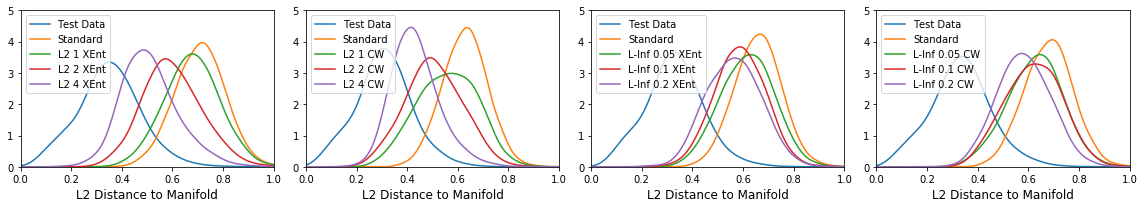

In [4]:
ress = unpickle('results/gradient/exp1/results_cw.pickle')

plt.figure(figsize=(16,3))

for i, res in enumerate(ress):
    
    plt.subplot(1,4,i + 1)
    
    for j, (name, l2_dist) in enumerate(res[2]):
        
        if name == 'Test Data':
            
            xmin = np.min(l2_dist)
            xmax = np.max(l2_dist)

        xs, ys = hist_kde((l2_dist - xmin) / (xmax - xmin), [0.0,1.0])
        plt.plot(xs, ys, label=name)
    
    plt.xlim([0,1])
    plt.ylim([0,5])
    plt.xlabel('L2 Distance to Manifold', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()

plt.savefig('figs/gradient_mnist_cw.jpg', bbox_inches='tight', dpi=300)

plt.show()
plt.close()

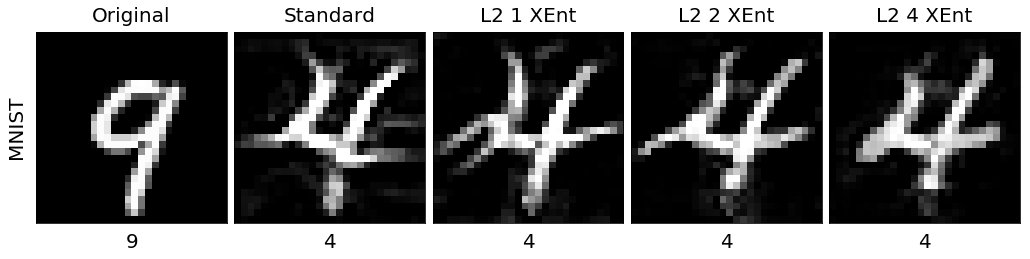

In [3]:
ress = unpickle('results/gradient/exp1/results_xent.pickle')
# ress = unpickle('results/gradient/exp1/results_cw.pickle')

i = 12

plt.figure(figsize=(3 * len(ress[0][0]), 6))

for j, (name, x) in enumerate(ress[0][0]):
    
    plt.subplot(2, len(ress[0][0]), j + 1)
    plt.imshow(x[i].reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Original' if name == 'Test Data' else name, fontsize=20, pad=10)
    
    if j == 0:
        plt.xlabel('9', fontsize=20, labelpad=10)
    else:
        plt.xlabel('4', fontsize=20, labelpad=10)
    
    if j == 0:
        
        plt.ylabel('MNIST', fontsize=20, labelpad=10)

plt.tight_layout()
plt.subplots_adjust(wspace=-0.15, hspace=0.03)

plt.savefig('figs/attack_mnist.jpg', bbox_inches='tight', dpi=300)

plt.show()

plt.close()